# PyTorch: Convolutional Network Fashion- MNIST

En este trabajo entrenaremos dos redes neuronales utilizando el framework  ``Pytorch``. Analizaremos la tarea de clasificación de imágenes, utilizando para ello dos arquitecturas diferentes: redes **feed-forward** (perceptrón con una capa unica y sin convolucionar) y redes **convolucionales**.

<!-- **Nota:** Esta es una adaptación de un colab provisto en clase.  -->
## Tabla de contenidos

- [1. Ojetivos](#objetivos)

- [2. Obtención y preparación del dataset](#dataset)
    - [2.1. Veamos algunos ejemplos.](#ejemplos)

- [3. Creación de los modelos](#creacion_modelo)

    - [3.1 Red con una unica capa oculta](#modelo1)
    - [3.2 Red Convolucional](#modelo2)

- [4. Comparativa CNN vs Perceptron con 1 capa oculta](#comparativa)

    - [4.1. CNN](#CNN)
    - [4.2. Perceptron](#perceptron)
    
<!-- - [5. Caso de uso](#ruido_gaussiano)
    - [5.1. Comparativa aleatoria](#aleat)
    - [5.2. Comparativa arbitraria](#arb) -->
- [5. Refs](#refs)



<a id="objetivos"></a>
## 1. Objetivos

A) Implementá una red neuronal fedforward multicapa y convolucional para aprender a clasificar las imágenes de la base de datos Fashion-MNIST. La red debe tener 784 unidades de entrada y 10 de salida. Definı́ la arquitectura que creas adecuada (número de capas, tamaños de las capas, unidades de activación, dropout, etc). Elegı́ la función de pérdida que creas adecuada, y usá el algoritmo de descenso por el gradiente que creas más conveniente según tu entender.

B) Elegı́ la función de pérdida que creas adecuada, y usá el algoritmo de descenso por el gradiente que
creas más conveniente para entrenear a la red.

C) Utilizando los conceptos de conjuntos de entrenamiento, validación y prueba, compará el rendimiento
de la red convolucional profunda con los mejores resultados obtenidos con una red de una sola capa oculta
y sin convolución y comentá.

## Importando librerías

Importamos librerías, configuramos los gráficos, etc.

In [37]:
import numpy as np                          ## Computación científica (vectores, matrices, etc.)
import pandas as pd                         ## pandas

from tqdm.notebook import tqdm              ## Barras de progreso

import pickle                               ## Para guardar en y leer de archivos, objetos de Python

import torch                                ## Framework de redes neturonales
from torch import nn                        ## Clases de redes neuronales
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from torchvision import datasets

## Convierte una imagen en un tensor de PyTorch, normalizado en el rango [0, 1]
from torchvision.transforms import ToTensor

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CyclicLR


## Librerías de visualización
import matplotlib.pyplot as plt             ## Gráficos varios
import seaborn as sns                       ## Gráficos más específicos



## Configuración general
sns.set()
sns.set_context('talk')
%matplotlib inline

In [38]:
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler

Vemos si la GPU está disponible. Si lo está, la utilizaremos, y si no, usaremos una CPU.

In [39]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

<a id="dataset"></a>
## 2. Obtención y preparación del dataset

Como el dataset es relativamente pequeño, lo descargamos en el momento y lo almacenamos en una carpeta local temporal. Al cerrar la sesión, los archivos serán eliminados.





In [40]:
## Descargamos el conjunto de entrenamiento
training_data = datasets.FashionMNIST(
    root="data",          ## Carpeta de descarga
    train=True,           ## Elegimos el conjunto de entrenamiento
    download=True,        ## Pedimos que lo descargue
    transform=ToTensor()  ## Lo transformamos en un "tensor" normalizado entre 0 y 1
)

## Descargamos el conjunto de evaluación
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Vemos cómo está estructurado el dataset

In [41]:
print(training_data, end='\n---------\n\n')
print(test_data, end='\n---------\n')

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
---------

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
---------


<a id="ejemplos"></a>
### 2.1 Veamos algunos ejemplos.

Graficamos al azar algunas imágenes, con sus correspondientes etiquetas.

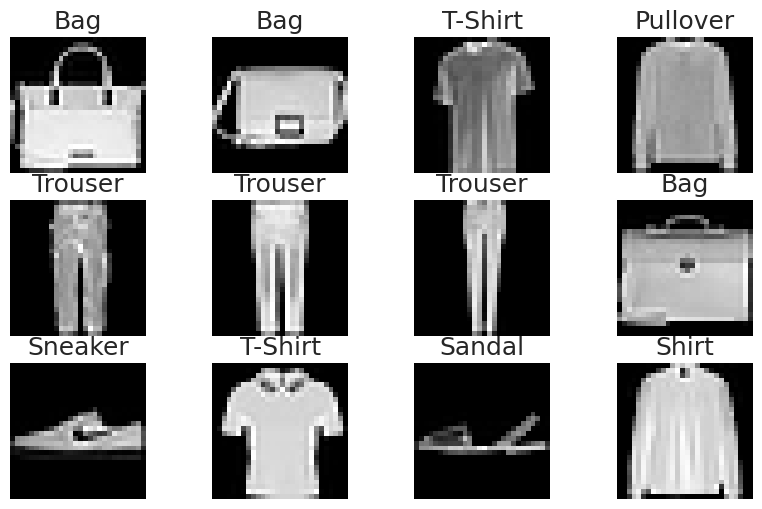

In [42]:
## Definimos el diccionario de etiquetas
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Esto lo puedo pasar a una funcion si lo voy a usar recurrentemente

## Construimos el gráfico
figure = plt.figure(figsize=(10, 6))
cols, rows = 4, 3
for i in range(1, cols*rows + 1):
    ## Elegimos muestras al azar para visualizar
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        ## El método squeeze elimina dimensiones con un
        ## sólo elemento. En este caso, la dimensión C
        ## (channel). Esta dimensión es trivial porque
        ## las imágenes son en escala de grises. Si fuese
        ## RGB, tendríamos 3 canales, uno para cada color.
        img.squeeze(),
        cmap="gray"
    )
plt.show()

El dataset esta balanceado?

In [43]:
train_labels = pd.Series([training_data[i][1] for i in range(len(training_data))])
test_labels = pd.Series([test_data[i][1] for i in range(len(test_data))])

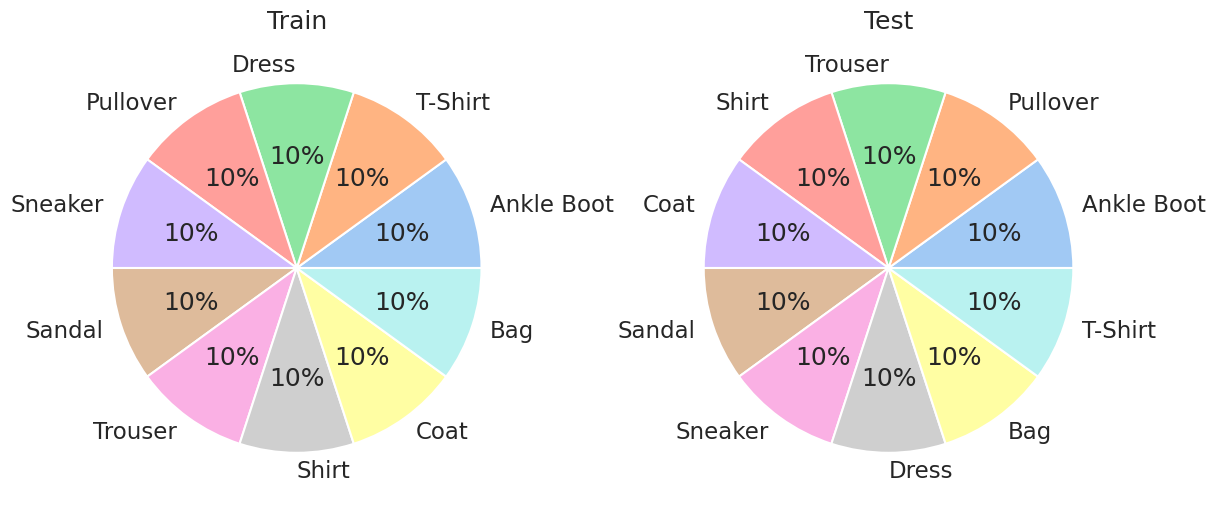

In [44]:
train_count= train_labels.value_counts()
test_count= test_labels.value_counts()
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(train_count)]
fig, ax = plt.subplots(1,2,figsize=(14,6))
#create pie chart
ax[0].pie(train_count, labels = train_count.index.map(labels_map), colors = colors, autopct='%.0f%%')
ax[0].set_title("Train")
ax[1].pie(test_count, labels = test_count.index.map(labels_map), colors = colors, autopct='%.0f%%')
ax[1].set_title("Test")
plt.show()


Pasamos el ``Dataset`` como argumento a  ``DataLoader``. De esta manera encapsulamos el dataset en un iterable que soporta varias operaciones útiles, como trabajar por batch, hacer sampling, paralelizar el cómputo, etc.

Elegimos un tamaño de batch de 64 ejemplos. Cada elemento que nos devuelva el iterable va a contener 64 ejemplos con sus atributos y sus etiquetas.

In [45]:
batch_size = 64

## Creamos los data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Dimensiones de X [N, C, H, W]: ", X.shape)
    print("Dimensiones de y: ", y.shape, y.dtype)
    break

Dimensiones de X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Dimensiones de y:  torch.Size([64]) torch.int64


<a id="creacion_modelo"></a>
## 3. Creamos el modelo

Todos los modelos en `pytorch` se definen como subclases de una clase genérica llamada `Module`.

Nuestro **primer modelo** será una red de tipo **perceptrón multicapa**, con una capa oculta y función de activación de tipo **Rectified Linear Unit (ReLU)**.

![picture](https://static.packt-cdn.com/products/9781786468574/graphics/B05474_04_05.jpg)


El segundo modelo será una **red convolucional profunda**, con la misma función de activación

![picture](https://miro.medium.com/max/2000/1*7K4ZTTfZb-hbjoADbisHAg.png)

<a id="modelo1"></a>
### 3.1 Red con una unica capa oculta

In [46]:
## Definimos el primer modelo
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()

        ## "Achatamos" la matriz de 28x28 píxeles,
        ## transformandola en un vector de 784 elementos
        self.flatten = nn.Flatten()

        ## Definimos el perceptrón multicapa con las
        ## siguientes capas:
        ##
        ## Entrada:        784 neuronas
        ## 1º capa oculta: 512 neuronas
        ## Salida:         10  neuronas
        ##
        ## Entre capa y capa, utilizamos función de
        ## activación ReLU
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.softmax(x)
        return x


<a id="modelo2"></a>
### 3.2 Red convolucional

Nota: Al final este no fue seleccionado, sino el siguiente. Solo lo dejo por completitud y para no andar recortando todo el codigo.

In [47]:

## Definimos el segundo modelo
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        ## Primera capa convolucional:
        ## construimos 32 canales usando filtros (kernels) de 3x3
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                padding=1,
            ),
            ## Aplicamos Batch Normalization como regularización
            nn.BatchNorm2d(32),
            ## Aplicamos la función de activación
            nn.ReLU(),
            ## Reducimos la imagen con Max Pooling
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        ## Segunda capa convolucional:
        ## construimos 64 canales usando filtros (kernels) de 3x3
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                padding=0
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        ## "Achatamos" la salida de la última capa, de 64 canales
        ## de tamaño 6x6, transformandola en un vector de 64*6*6 elementos
        self.flatten = nn.Flatten()

        ## Después de las capas convoulucionales,
        ## agregamos algunas capas densas. La última, de 10
        ## neurnonas, es nuestra capa de salida
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 6 * 6, 600),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.Dropout(0.25), ## Regularizamos con dropout después de cada capa
            nn.ReLU(),
            nn.Linear(120, 10),
            nn.Dropout(0.25),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x


In [48]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization after the first convolution
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after the second convolution
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)   # Apply Batch Normalization
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)   # Apply Batch Normalization
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        output = self.fc2(x)
        output = nn.functional.log_softmax(output, dim=1)
        return output


Red neuronal convolucional utilizada

In [49]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization after the first convolution
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after the second convolution
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)   # Apply Batch Normalization
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)   # Apply Batch Normalization
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout3(x)
        output = self.fc3(x)
        output = nn.functional.log_softmax(output, dim=1)
        return output


In [50]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization after the first convolution
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after the second convolution
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100, 10)
        self.lr1 = nn.LeakyReLU(0.1)
        self.lr2 = nn.LeakyReLU(0.1)
        self.lr3 = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)   # Apply Batch Normalization
        x = self.lr1(x)
        x = self.conv2(x)
        x = self.bn2(x)   # Apply Batch Normalization
        x = self.lr2(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.lr3(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout3(x)
        output = self.fc3(x)
        output = nn.functional.log_softmax(output, dim=1)
        return output


In [51]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization after the first convolution
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after the second convolution
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100, 10)
        self.lr1 = nn.SiLU(0.1)
        self.lr2 = nn.SiLU(0.1)
        self.lr3 = nn.SiLU(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)   # Apply Batch Normalization
        x = self.lr1(x)
        x = self.conv2(x)
        x = self.bn2(x)   # Apply Batch Normalization
        x = self.lr2(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.lr3(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout3(x)
        output = self.fc3(x)
        output = nn.functional.log_softmax(output, dim=1)
        return output

In [52]:

## Creamos una instancia de nuestro modelo
## (un objeto de la clase correspondiente)
# #
# model = MultiLayerPerceptron()
# model_name = "Red neuronal con una capa oculta"
# model = CNN()
# model_name = "CNN" # Convolutional Neuronal Network

model = Net()
model_name = "Red Neuronal convolucional" # Convolutional Neuronal Network


## "enviamos" el modelo a la GPU o a la CPU,
## según esté disponible
model.to(device)

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (lr1): SiLU(inplace=True)
  (lr2): SiLU(inplace=True)
  (lr3): SiLU(inplace=True)
)


## Entrenamiento del modelo

Para entrenar el modelo, necesitamos definir una `función error` (loss function) y un `optimizador` (el algoritmo que intentará minimizar el error).

La función de costo que elegimos es la *Cross Entropy*, y el optimizador que elegimos es *Adamax*.

Si bien en el ciclic scheduler funciona mejor, en conjunto con el optimizer se demora bastante en converger por lo que el combo adamax  ReduceLROnPlateau funciona mejor combinando velocidad con potencia.

In [53]:
## Definimos la función error o "loss"
loss_fn = nn.CrossEntropyLoss()
loss_fn_name = 'CrossEntropy'

## Definimos el optimizador
## Una opción es usar el SGD



optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

## opcion 2
# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=0.001,
# )
# scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=2000, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, last_epoch=-1, verbose=True)


Para cada ciclo de entrenamiento, el modelo hace predicciones sobre el conjunto de entrenamiento, el cual se presenta en lotes (batchs), y hace *backpropagation* del error obtenido para ajustar los parámetros.

In [54]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Entrena el modelo una época.
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        batch_size = X.shape[0]

        ## Calculamos el error en la predicción
        pred = model(X)
        true = y
        loss = loss_fn(pred, true)

        ## Ajustamos los pesos haciendo backpropagation

        # Reiniciamos  los gradientes de los tensores optimizados.
        # Se deben reiniciar los gradientes antes de calcular nuevos gradientes para evitar acumular gradientes de cálculos previos.
        optimizer.zero_grad()

        # Esta línea se utiliza para calcular los gradientes del error (o pérdida) con respecto a todos los parámetros
        # que pueden ser entrenados (aprendidos) en la red neuronal. Esto se hace utilizando el algoritmo de retropropagación,
        # que propaga el error hacia atrás a través de la red, calculando la derivada de la pérdida con respecto a cada parámetro.
        loss.backward()
        #Esta línea se utiliza para actualizar los parámetros de la red neuronal utilizando los gradientes calculados en el paso anterior.
        # El optimizador se encarga de ajustar los parámetros según un algoritmo de optimización específico,
        # como descenso de gradiente estocástico (SGD) o Adam.
        optimizer.step()

        if batch % 100 == 0:
            train_loss = loss.item() / batch_size
            current = batch * batch_size
            print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")


También evaluamos el desempeño del modelo con respecto al conjunto de validación para asegurarnos de que esté aprendiendo.


In [55]:
def test(dataloader, model, loss_fn, verbose=True):
    """
    Evalúa el modelo sobre los datos presentados en el parámetro "dataloader",
    y calcula las métricas correspondientes.
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    accuracy = 100*correct
    if verbose:
      print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f}")

    return test_loss, accuracy

El proceso de entrenamiento se lleva a cabo en iteraciones llamadas épocas. Durante cada época, el modelo ajusta los parámetros para mejorar la predicción.

Imprimimos la precisión del modelo y la loss para cada época. Lo ideal es que la predicción aumente y que la loss disminuya con cada época.

In [56]:
epochs = 25
train_losses = []
test_losses = []
train_acc_values = []
test_acc_values = []
for epoch in range(1, epochs+1):
    print(f'Época {epoch}')
    ## Entreno una época del modelo
    train(train_dataloader, model, loss_fn, optimizer)

    ## Evaluo sobre el consjunto de entrenamiento
    print()
    print('Train performance:')
    train_loss, train_acc = test(train_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    train_acc_values.append(train_acc)

    ## Evaluo sobre el conjunto de evaluación
    print('Test performance:')
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
    test_acc_values.append(test_acc)
    print('-------------------------------------')
    print()
    scheduler.step(test_loss)

print("Done!")


Época 1
loss: 0.036019  [    0/60000]
loss: 0.007985  [ 6400/60000]
loss: 0.004189  [12800/60000]
loss: 0.006975  [19200/60000]
loss: 0.007426  [25600/60000]
loss: 0.006805  [32000/60000]
loss: 0.004481  [38400/60000]
loss: 0.007463  [44800/60000]
loss: 0.006349  [51200/60000]
loss: 0.005707  [57600/60000]

Train performance:
Accuracy: 89.29%, Avg loss: 0.004494
Test performance:
Accuracy: 87.97%, Avg loss: 0.005160
-------------------------------------

Época 2
loss: 0.004658  [    0/60000]
loss: 0.006072  [ 6400/60000]
loss: 0.003728  [12800/60000]
loss: 0.005506  [19200/60000]
loss: 0.004015  [25600/60000]
loss: 0.005865  [32000/60000]
loss: 0.002955  [38400/60000]
loss: 0.004830  [44800/60000]
loss: 0.004273  [51200/60000]
loss: 0.002777  [57600/60000]

Train performance:
Accuracy: 91.66%, Avg loss: 0.003525
Test performance:
Accuracy: 89.82%, Avg loss: 0.004354
-------------------------------------

Época 3
loss: 0.002431  [    0/60000]
loss: 0.004510  [ 6400/60000]
loss: 0.002592

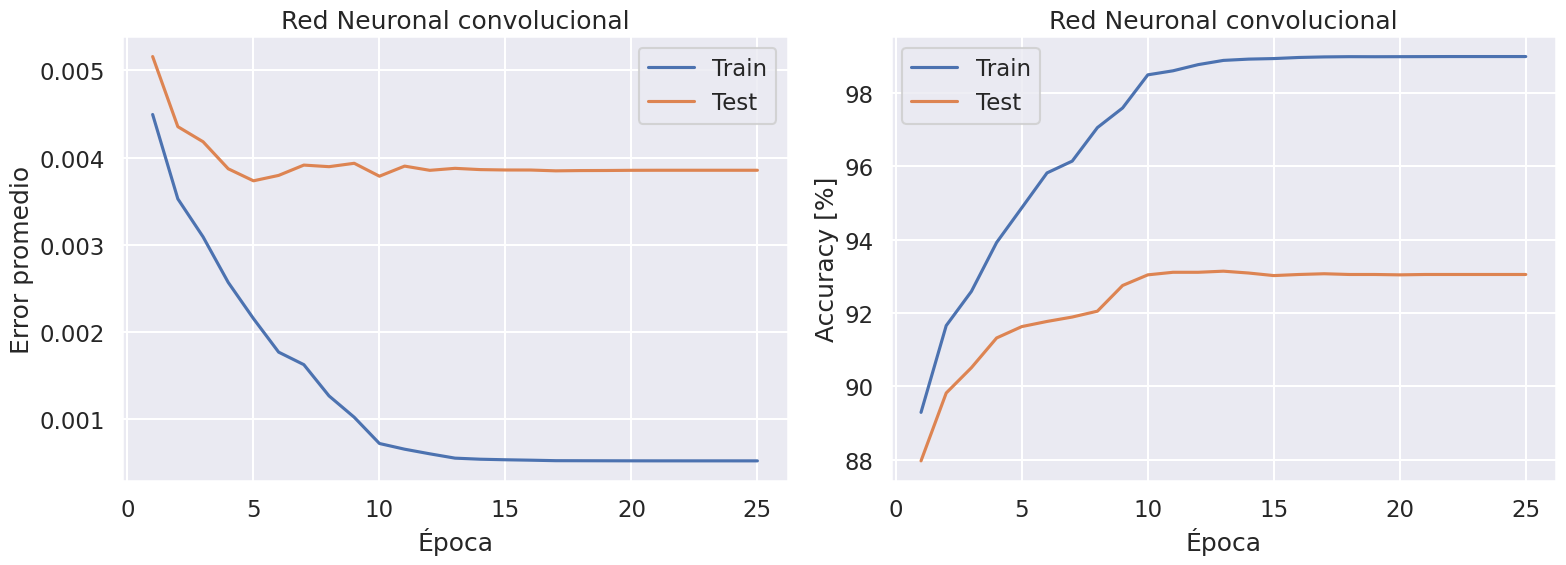

In [57]:
X = range(1, len(train_losses)+1)

fig, axes = plt.subplots(figsize=(16, 6), ncols=2)
ax = axes[0]
ax.set_xlabel('Época')
ax.set_ylabel('Error promedio')
ax.plot(X, train_losses, label='Train')
ax.plot(X, test_losses, label='Test')
ax.set_title(model_name)
ax.legend()

ax = axes[1]
ax.set_xlabel('Época')
ax.set_ylabel('Accuracy [%]')
ax.plot(X, train_acc_values, label='Train')
ax.plot(X, test_acc_values, label='Test')
ax.set_title(model_name)
ax.legend()
plt.tight_layout()
plt.savefig('net.png')
plt.show()

## Guardamos el modelo

Una forma estándar de guardar el modelo es "serializar" el diccionario con el estado interno del mismo, el cual contiene los parámetros del modelo.

In [58]:
filename_model = model_name+"-model.pth"

torch.save(model.state_dict(),filename_model)
print("Saved PyTorch Model State to "+filename_model)

Saved PyTorch Model State to Red Neuronal convolucional-model.pth


## Guardamos las curvas

In [59]:
filename_curvas = model_name+"-curvas.pkl"

with open(filename_curvas,'wb') as fh:
    pickle.dump((train_losses,test_losses,train_acc_values,test_acc_values),fh)

## Cargamos un modelo guardado

Para cargar un modelo almacenado, tenemos que recrear la estructura del modelo (definir una nueva instancia de nuestra clase) y cargar el diccionario con el estado interno (los parámetros).

In [60]:
model = MultiLayerPerceptron().to(device)
model = CNN().to(device)
# model = Net().to(device)
# model.load_state_dict(torch.load(filename_model))

## Cargamos las curvas

In [61]:
# solo para revisar modelos pre entrenados
filename_curvas = 'Red Neuronal convolucional-curvas.pkl'

In [62]:
with open (filename_curvas,'rb') as fh:
    train_losses,test_losses,train_acc_values,test_acc_values = pickle.load(fh)

## Observamos las predicciones

In [63]:
def plot_img(data, idx):
    """
    Grafica un ejemplo
    """
    figure = plt.figure(figsize=(4, 4))
    img, label = data[idx]
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

def show_prediction(example):
    """
    Muestra la predicción para un ejemplo
    """
    model.eval()
    x, y = test_data[example][0], test_data[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = softmax(sorted.values[0], dim=-1)
    indices = sorted.indices[0]
    print(
        f'Etiqueta correcta: {labels_map[y]}',
        end='\n----------------\n'
    )
    print('Etiqueta     Probabilidad')
    for v, idx in list(zip(values,indices))[::-1]:
        label_pred = labels_map[idx.item()]
        print(f'{label_pred:13}{v.item():.5f}')

In [64]:
def show_prediction2(data,example):
    import seaborn as sns
    """
    Muestra la predicción para un ejemplo
    """
    # imagen considerada

    img, label = data[example]
    # prediccion
    model.eval()
    x, y = test_data[example][0], test_data[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = softmax(sorted.values[0], dim=-1)
    indices = sorted.indices[0]

    indices = np.array(indices)

    def map_values(indices, dictionary):
        values = []
        for i in indices:

            values.append(dictionary[i])
        return values

    # print(indices,map_values(indices,labels_map))
    #plots

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Primer subplot
    axs[0].imshow(img.squeeze(), cmap="gray")
    axs[0].set_axis_off()
    axs[0].set_title('Imagen Original')

    # Segundo subplot
    axs[1].barh(map_values(indices,labels_map),values,label='probs')

    for i, v in enumerate(values.numpy()):
        axs[1].text( v+v*0.1,i, str(round(v,2)), ha='center',fontsize=9)

    axs[1].set_title('Prediccion')
    axs[1].legend(loc='lower right')
    # Ajustar los espacios entre subplots y guardar la figura
    fig.tight_layout()



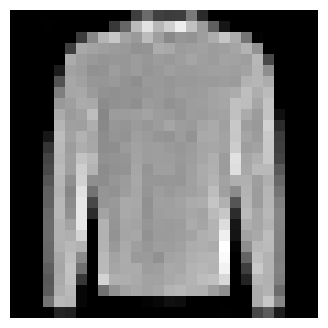

In [65]:
example = np.random.randint(0,1000)
plot_img(test_data, example)
# show_prediction2(test_data,example)

In [66]:
np.random.randint(0,1000)

640

In [67]:
# example = 16
# plot_img(test_data, example)
# show_prediction(example)

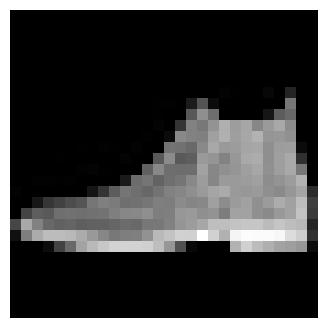

Etiqueta correcta: Ankle Boot
----------------
Etiqueta     Probabilidad
Dress        0.10472
Bag          0.10317
Trouser      0.10161
Pullover     0.10017
Ankle Boot   0.09853
Sandal       0.09836
Sneaker      0.09836
Coat         0.09836
Shirt        0.09836
T-Shirt      0.09836


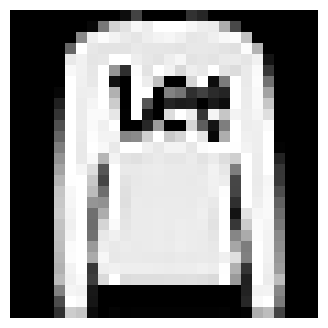

Etiqueta correcta: Pullover
----------------
Etiqueta     Probabilidad
Dress        0.10481
Bag          0.10389
Trouser      0.10212
Pullover     0.10108
Ankle Boot   0.09802
Coat         0.09802
Sandal       0.09802
Sneaker      0.09802
Shirt        0.09802
T-Shirt      0.09802


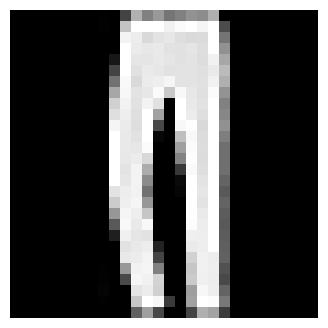

Etiqueta correcta: Trouser
----------------
Etiqueta     Probabilidad
Dress        0.10526
Bag          0.10385
Trouser      0.10157
Pullover     0.10014
Ankle Boot   0.09820
Coat         0.09820
Sandal       0.09820
Sneaker      0.09820
Shirt        0.09820
T-Shirt      0.09820


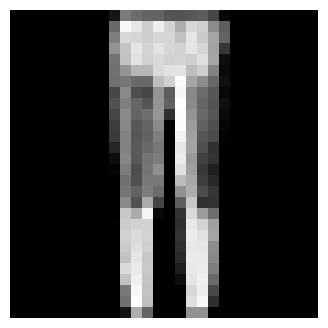

Etiqueta correcta: Trouser
----------------
Etiqueta     Probabilidad
Dress        0.10512
Bag          0.10388
Trouser      0.10158
Pullover     0.09994
Ankle Boot   0.09825
Coat         0.09825
Sandal       0.09825
Sneaker      0.09825
Shirt        0.09825
T-Shirt      0.09825


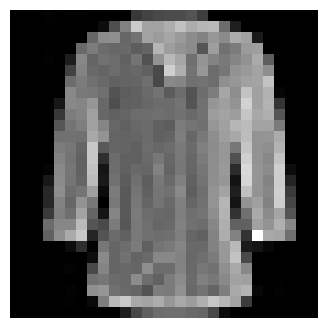

Etiqueta correcta: Shirt
----------------
Etiqueta     Probabilidad
Dress        0.10552
Bag          0.10312
Trouser      0.10179
Pullover     0.10059
Ankle Boot   0.09816
Coat         0.09816
Sandal       0.09816
Sneaker      0.09816
Shirt        0.09816
T-Shirt      0.09816


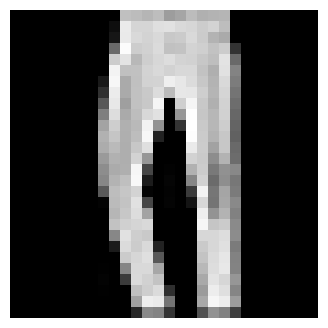

Etiqueta correcta: Trouser
----------------
Etiqueta     Probabilidad
Dress        0.10519
Bag          0.10381
Trouser      0.10168
Pullover     0.10031
Ankle Boot   0.09817
Coat         0.09817
Sandal       0.09817
Sneaker      0.09817
Shirt        0.09817
T-Shirt      0.09817


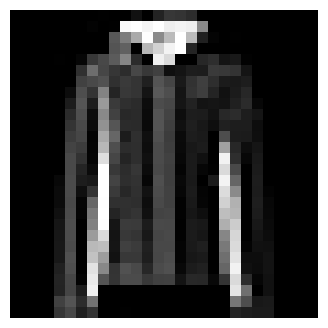

Etiqueta correcta: Coat
----------------
Etiqueta     Probabilidad
Dress        0.10531
Bag          0.10334
Trouser      0.10159
Pullover     0.10047
Ankle Boot   0.09859
Sandal       0.09814
Sneaker      0.09814
Coat         0.09814
Shirt        0.09814
T-Shirt      0.09814


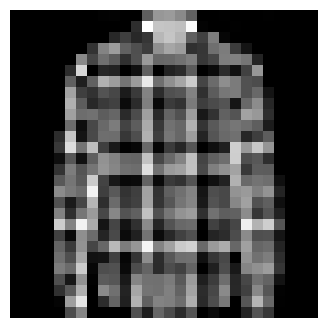

Etiqueta correcta: Shirt
----------------
Etiqueta     Probabilidad
Dress        0.10508
Bag          0.10327
Trouser      0.10174
Pullover     0.10040
Ankle Boot   0.09825
Coat         0.09825
Sandal       0.09825
Sneaker      0.09825
Shirt        0.09825
T-Shirt      0.09825


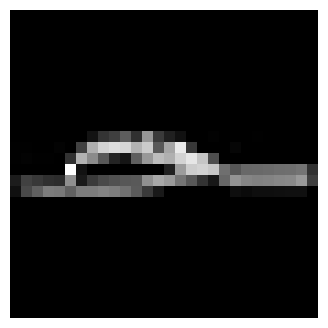

Etiqueta correcta: Sandal
----------------
Etiqueta     Probabilidad
Dress        0.10500
Bag          0.10337
Pullover     0.10099
Trouser      0.10098
Ankle Boot   0.09836
Sandal       0.09826
Sneaker      0.09826
Coat         0.09826
Shirt        0.09826
T-Shirt      0.09826


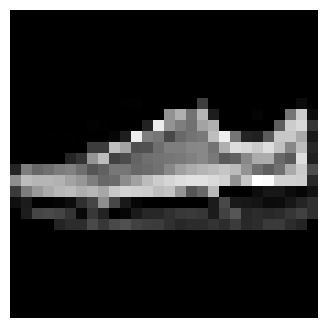

Etiqueta correcta: Sneaker
----------------
Etiqueta     Probabilidad
Dress        0.10520
Bag          0.10340
Trouser      0.10148
Pullover     0.10099
Ankle Boot   0.09815
Coat         0.09815
Sandal       0.09815
Sneaker      0.09815
Shirt        0.09815
T-Shirt      0.09815


In [68]:
for i in range(10):

    plot_img(test_data, i)
    show_prediction(i)

## Analizamos el proceso de aprendizaje

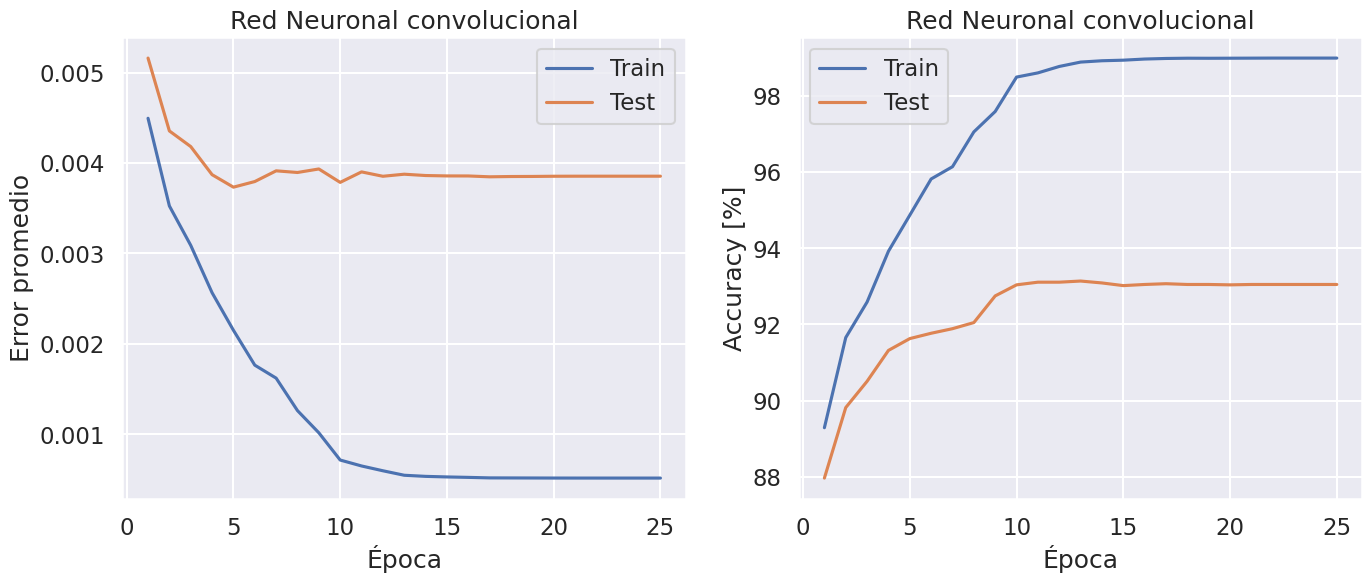

In [69]:
X = range(1, len(train_losses)+1)

fig, axes = plt.subplots(figsize=(16, 6), ncols=2)
ax = axes[0]
ax.set_xlabel('Época')
ax.set_ylabel('Error promedio')
ax.plot(X, train_losses, label='Train')
ax.plot(X, test_losses, label='Test')
ax.set_title(model_name)
ax.legend()

ax = axes[1]
ax.set_xlabel('Época')
ax.set_ylabel('Accuracy [%]')
ax.plot(X, train_acc_values, label='Train')
ax.plot(X, test_acc_values, label='Test')
ax.set_title(model_name)
ax.legend()
plt.show()

In [70]:
def obtener_etiquetas_predicciones(modelo, dataset):
    etiquetas_reales = []
    predicciones = []

    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelo.to(dispositivo)
    modelo.eval()

    with torch.no_grad():
        for imagenes, etiquetas in dataset:
            imagenes = imagenes.unsqueeze(0).to(dispositivo)  # Expande la dimensión del tensor de imágenes

            salida = modelo(imagenes)
            _, prediccion = torch.max(salida, 1)

            etiquetas_reales.append(etiquetas)
            predicciones.append(prediccion.cpu().numpy())

    return np.array(etiquetas_reales), np.array(predicciones)


# Ejemplo de uso
modelo_pytorch = model  # Reemplaza con tu modelo de PyTorch
etiquetas_reales, predicciones = obtener_etiquetas_predicciones(modelo_pytorch, test_data)



0.1001


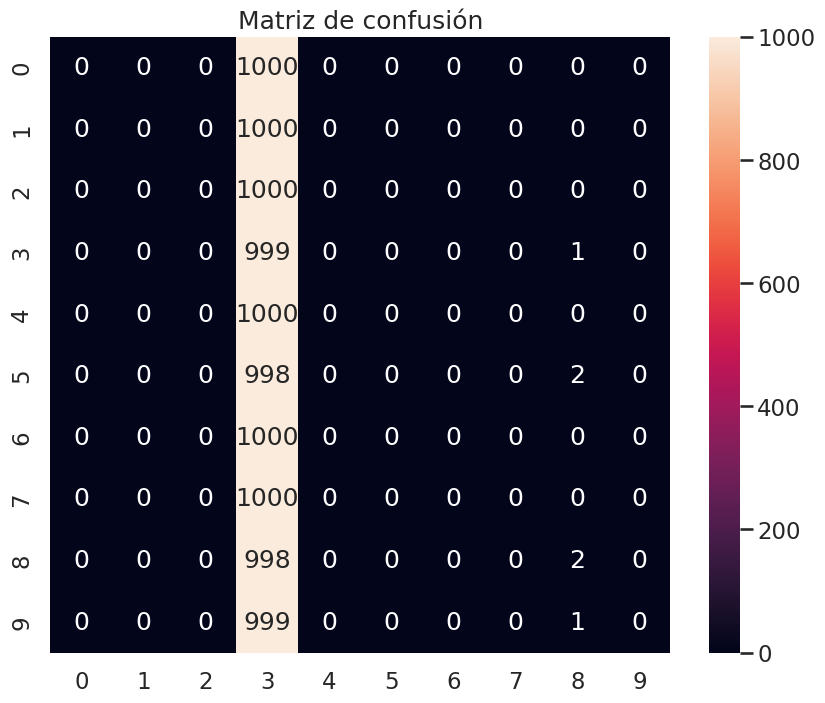

In [71]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(etiquetas_reales,predicciones))
plt.figure(figsize = (10,8))
sns.heatmap(confusion_matrix(etiquetas_reales,predicciones),annot=True,fmt='d')
plt.title('Matriz de confusión')
plt.savefig('confusion.png')

In [72]:
import matplotlib.pyplot as plt

# # Crea una instancia del modelo
# model = Net()

# # Extrae la arquitectura de la red para generar el gráfico
# from torchviz import make_dot
# x = torch.randn(1, 1, 28, 28)  # Ejemplo de tamaño de entrada
# y = model(x)

# # Crea el gráfico
# make_dot(y, params=dict(model.named_parameters())).render("model_graph", format="png")
# # Asegúrate de tener instalada la librería torchviz antes de ejecutar este código. Puedes

In [73]:
from torchview import draw_graph
import graphviz

class Net_simple(nn.Module):
    def __init__(self):
        super(Net_simple, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization after the first convolution
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after the second convolution
        # self.dropout1 = nn.Dropout(0.25)
        # self.dropout2 = nn.Dropout(0.25)
        # self.dropout3 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn1(x)   # Apply Batch Normalization
        # x = nn.functional.relu(x)
        x = self.conv2(x)
        # x = self.bn2(x)   # Apply Batch Normalization
        # x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        # x = nn.functional.relu(x)
        # x = self.dropout2(x)
        x = self.fc2(x)
        # x = nn.functional.relu(x)
        # x = self.dropout3(x)
        output = self.fc3(x)
        output = nn.functional.log_softmax(output, dim=1)
        return output


# graphviz.set_jupyter_format('png')
model_graph = draw_graph(Net_simple(), input_size=(1, 1, 28, 28), device='meta', save_graph = True)
model_graph.visual_graph
# plt.savefig('esquema.png')

ModuleNotFoundError: ignored

#### Referencias:

[A Comprehensive Guide to Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/

[Documentación de PyTorch](https://pytorch.org/)

[Tutoriales](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)